In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import multi_gpu_model
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_accuracy(model):
    accuracy = model.history['acc']
    val_accuracy = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [3]:
# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Add dimension for input-shape purpose
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test, 3)

# Normalize the inputs
x_train = tf.keras.utils.normalize(x_train, axis=1) # normalize the train data
x_test = tf.keras.utils.normalize(x_test, axis=1) # normalize the test data

# Make outputs categorical - one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split the train data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

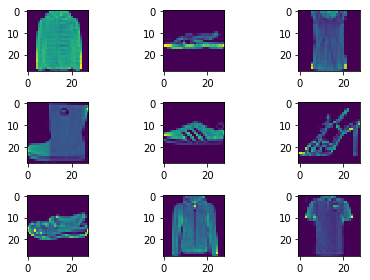

In [4]:
# Look at the first 9 images from the dataset
images = range(0,9)
for i in images:
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].reshape(28,28))
    
#Show the plot
plt.tight_layout()

### 4 convolutional layers + 2 maxpooling + 1 dense (VGG16)

In [5]:
model_conv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding ='same',input_shape=(28, 28,1)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding ='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding='same'),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation="softmax")])

In [6]:
# Train the model on 2 gpus, batch_size=64 for each of them
model = multi_gpu_model(model_conv, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=128)

Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 14s 275us/step - loss: 0.4486 - acc: 0.8349 - val_loss: 0.3078 - val_acc: 0.8824
Epoch 2/10
51000/51000 [==============================] - 12s 232us/step - loss: 0.2706 - acc: 0.8997 - val_loss: 0.2454 - val_acc: 0.9077
Epoch 3/10
51000/51000 [==============================] - 12s 230us/step - loss: 0.2210 - acc: 0.9165 - val_loss: 0.2222 - val_acc: 0.9213
Epoch 4/10
51000/51000 [==============================] - 12s 232us/step - loss: 0.1843 - acc: 0.9310 - val_loss: 0.2096 - val_acc: 0.9237
Epoch 5/10
51000/51000 [==============================] - 12s 231us/step - loss: 0.1496 - acc: 0.9426 - val_loss: 0.2167 - val_acc: 0.9224
Epoch 6/10
51000/51000 [==============================] - 12s 229us/step - loss: 0.1180 - acc: 0.9555 - val_loss: 0.2514 - val_acc: 0.9160
Epoch 7/10
51000/51000 [==============================] - 12s 232us/step - loss: 0.0942 - acc: 0.9650 - val_loss: 0.2

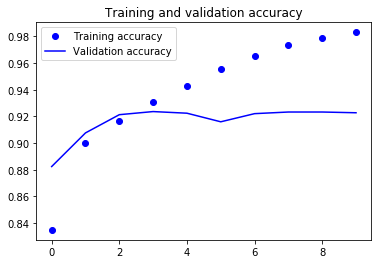

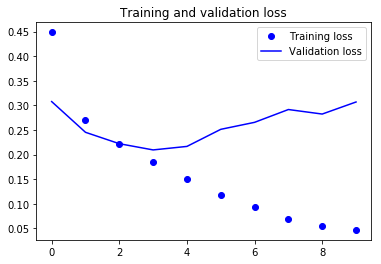

In [7]:
plot_accuracy(history)

It is overfitting. Lets try data augmentation

### Data augmentation

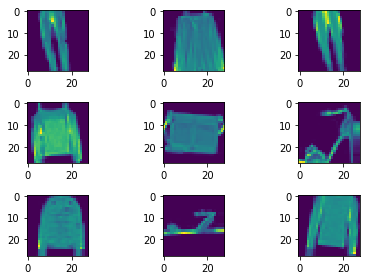

In [8]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=0.3,
                               height_shift_range=0.1, zoom_range=0.1)
#data_gen.fit(x_train)

# Show 9 augmented images
for x_batch, y_batch in data_gen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(28, 28))
    plt.tight_layout()
    break

In [9]:
history = model.fit_generator(data_gen.flow(x_train, y_train, batch_size=128),
                               epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
399/399 [==============================] - 13s 32ms/step - loss: 0.3749 - acc: 0.8571 - val_loss: 0.2116 - val_acc: 0.9218
Epoch 2/10
399/399 [==============================] - 12s 31ms/step - loss: 0.3004 - acc: 0.8863 - val_loss: 0.2252 - val_acc: 0.9216
Epoch 3/10
399/399 [==============================] - 12s 31ms/step - loss: 0.2718 - acc: 0.8970 - val_loss: 0.2046 - val_acc: 0.9267
Epoch 4/10
399/399 [==============================] - 12s 30ms/step - loss: 0.2551 - acc: 0.9036 - val_loss: 0.2135 - val_acc: 0.9246
Epoch 5/10
399/399 [==============================] - 12s 30ms/step - loss: 0.2433 - acc: 0.9074 - val_loss: 0.2143 - val_acc: 0.9228
Epoch 6/10
399/399 [==============================] - 12s 31ms/step - loss: 0.2322 - acc: 0.9125 - val_loss: 0.2113 - val_acc: 0.9226
Epoch 7/10
399/399 [==============================] - 12s 30ms/step - loss: 0.2247 - acc: 0.9153 - val_loss: 0.1971 - val_acc: 0.9312
Epoch 8/10
399/399 [==============================] - 12s 30ms

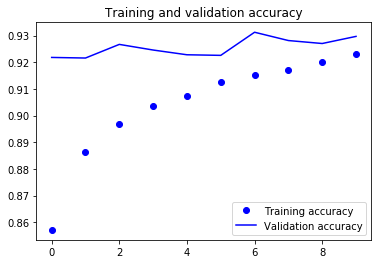

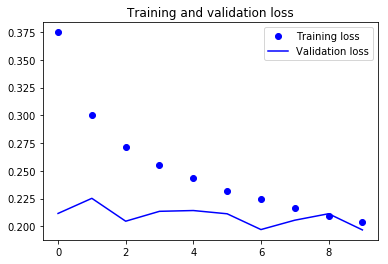

In [10]:
plot_accuracy(history)

In [11]:
score = history.model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save('/home/tgeorgiopoulos/Dropbox/MSc Data Science/CNN_FMNIST')

10000/10000 [==============================] - 1s 72us/step
Test score: 0.21714527928829194
Test accuracy: 0.9248


### Data augmentation + Dropout + Regularizer

In [12]:
model_conv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding ='same',input_shape=(28, 28,1)),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding ='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding='same'),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")])

In [13]:
model = multi_gpu_model(model_conv, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(data_gen.flow(x_train, y_train, batch_size=128),
                               epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
399/399 [==============================] - 14s 35ms/step - loss: 0.7166 - acc: 0.7517 - val_loss: 0.4255 - val_acc: 0.8628
Epoch 2/10
399/399 [==============================] - 13s 32ms/step - loss: 0.5127 - acc: 0.8296 - val_loss: 0.3755 - val_acc: 0.8889
Epoch 3/10
399/399 [==============================] - 13s 33ms/step - loss: 0.4641 - acc: 0.8505 - val_loss: 0.3447 - val_acc: 0.8987
Epoch 4/10
399/399 [==============================] - 13s 32ms/step - loss: 0.4365 - acc: 0.8612 - val_loss: 0.3482 - val_acc: 0.8939
Epoch 5/10
399/399 [==============================] - 13s 33ms/step - loss: 0.4188 - acc: 0.8684 - val_loss: 0.3365 - val_acc: 0.9022
Epoch 6/10
399/399 [==============================] - 13s 32ms/step - loss: 0.4024 - acc: 0.8775 - val_loss: 0.3167 - val_acc: 0.9088
Epoch 7/10
399/399 [==============================] - 13s 32ms/step - loss: 0.3949 - acc: 0.8796 - val_loss: 0.3197 - val_acc: 0.9084
Epoch 8/10
399/399 [==============================] - 13s 32ms

So, because of no everfitting, dropout and regularization don't help. Lets load the previous model and try ensembling

### Data augmentation and ensembling

In [14]:
model = tf.keras.models.load_model('/home/tgeorgiopoulos/Dropbox/MSc Data Science/CNN_FMNIST')

In [15]:
def fit_model():
    model = tf.keras.models.load_model('/home/tgeorgiopoulos/Dropbox/MSc Data Science/CNN_FMNIST')
    model = multi_gpu_model(model, gpus=2)
    model.compile(tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(data_gen.flow(x_train, y_train, batch_size=128),
                               epochs=10, validation_data=(x_val, y_val))
    model.optimizer.lr=0.0001
    model.fit_generator(data_gen.flow(x_train, y_train, batch_size=128),
                               epochs=10, validation_data=(x_val, y_val))
    return model

In [16]:
models = [fit_model() for i in range(5)]

Epoch 1/10
399/399 [==============================] - 14s 35ms/step - loss: 0.2032 - acc: 0.9227 - val_loss: 0.2050 - val_acc: 0.9281
Epoch 2/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1913 - acc: 0.9281 - val_loss: 0.2054 - val_acc: 0.9301
Epoch 3/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1867 - acc: 0.9292 - val_loss: 0.1886 - val_acc: 0.9340
Epoch 4/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1827 - acc: 0.9319 - val_loss: 0.2033 - val_acc: 0.9306
Epoch 5/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1760 - acc: 0.9326 - val_loss: 0.2092 - val_acc: 0.9281
Epoch 6/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1779 - acc: 0.9325 - val_loss: 0.1926 - val_acc: 0.9381
Epoch 7/10
399/399 [==============================] - 13s 32ms/step - loss: 0.1694 - acc: 0.9358 - val_loss: 0.2039 - val_acc: 0.9347
Epoch 8/10
399/399 [==============================] - 13s 32ms

In [17]:
evals = np.array([m.evaluate(x_test, y_test, batch_size=128) for m in models])

10000/10000 [==============================] - 1s 92us/step


In [18]:
all_preds = np.stack([m.predict(x_test, batch_size=128) for m in models])
avg_preds = all_preds.mean(axis=0)

In [19]:
score = history.model.evaluate(x_test, avg_preds, batch_size=128)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 83us/step
Test score: 0.32565595121383667
Test accuracy: 0.9301
